In [1]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import torch

_download_ = False
folder = "data/"

C:\Users\orteg\AppData\Local\Temp\ipykernel_29732\1347802196.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 1 - Data download and import

In [2]:
if _download_:
    os.system("python download_data.py")

In [3]:
data = pd.read_pickle(folder + "sneakers_dataset.pkl")

In [19]:
images = data[0]
labels = data[1]

In [20]:
images.shape

(19919,)

## 2 - Data Visualization

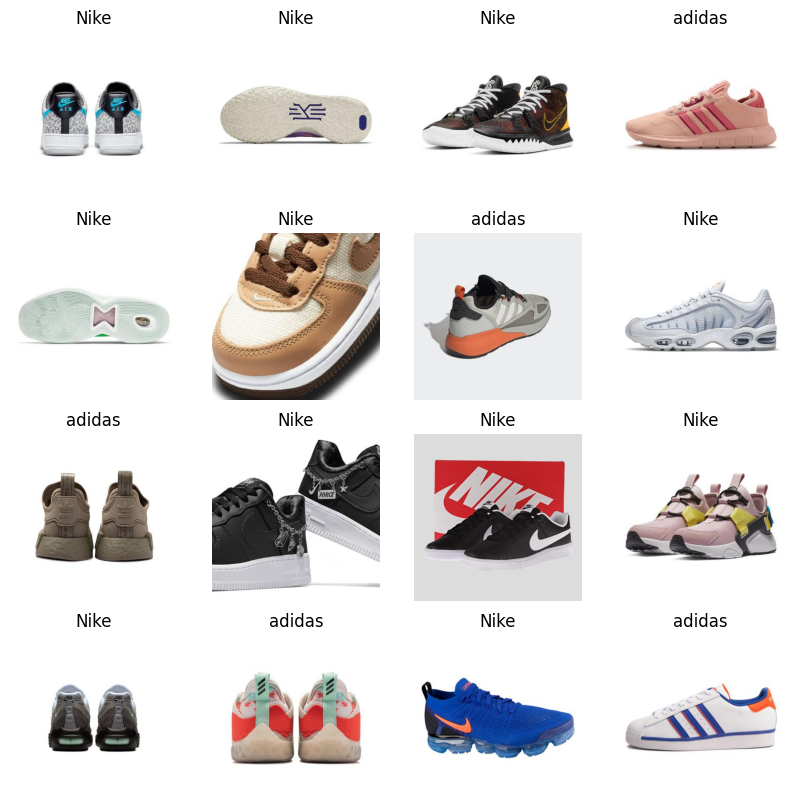

In [21]:
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        rint = np.random.randint(len(images))
        img, brand = images[rint], labels[rint]
        ax[i, j].imshow(np.array(img))
        ax[i, j].set_title(brand)
        ax[i, j].axis("off")
plt.show()

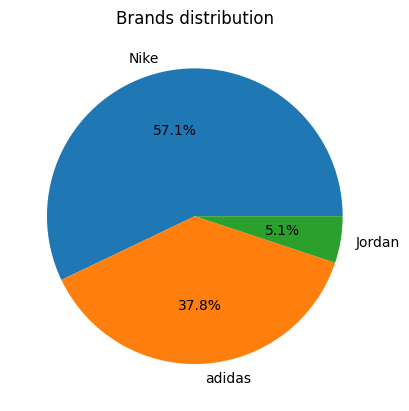

In [23]:
#labels distribution
brands = labels.value_counts()
plt.pie(brands, labels=brands.index, autopct='%1.1f%%')
plt.title("Brands distribution")
plt.show()

In [29]:
print("All images have the same dimensions:", all([img.shape == images[0].shape for img in images]))

All images have the same dimensions: False


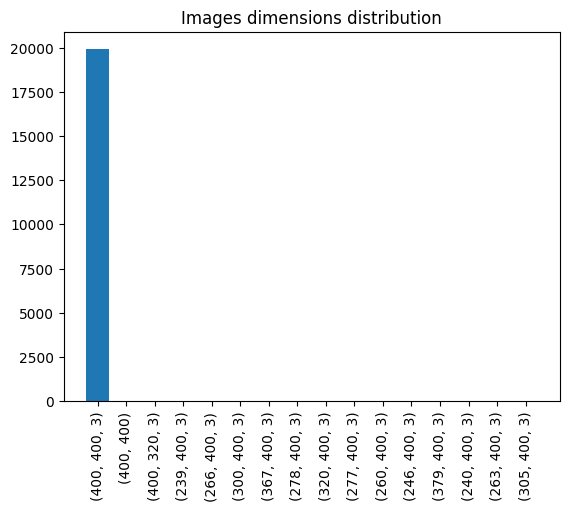

In [25]:
sizes = np.array([str(img.shape) for img in images])
sizes = pd.Series(sizes).value_counts()
plt.bar(sizes.index, sizes.values)
plt.xticks(rotation=90)
plt.title("Images dimensions distribution")
plt.show()

## 3 - Data Preprocessing

##### First, we isolate X and y

In [32]:
# X = [img for img, _ in images]
# y = [brand for _, brand in images]

# do dataloader

##### Resize images 

In [34]:
#X = [np.array(Image.fromarray(img).resize((400, 400))) for img in X]

# do dataloader

##### We normalize images

In [26]:
# X = [img / 255 for img in X]
# do dataloader

## 4 - Prediction

In [39]:
#load a pretrained model for image classification
model = torch.hub.load("pytorch/vision", "resnet50", weights="IMAGENET1K_V2")

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in zip(X_test, y_test):
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = correct / total
print(f"Validation Accuracy: {accuracy}")

Downloading: "https://github.com/pytorch/vision/zipball/main" to C:\Users\orteg/.cache\torch\hub\main.zip


RuntimeError: operator torchvision::nms does not exist

In [ ]:
def train(path):
    